In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('Cancer_Data.csv')

y = np.where(data.diagnosis == 'M', 1, 0)
X = data.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1)
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)


scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

X_train.columns = features
X_test.columns = features

In [31]:
# RANDOM FOREST COARSE SEARCH
params = {'bootstrap': [False, True],
         'max_features': [0.3, 0.5, 0.8],
          'max_depth': [12,15,18],
          'max_leaf_nodes':[1100,1200,1300]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

rf = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring = ['accuracy', 'recall'], refit='accuracy')

rf.fit(X_train, y_train)

print('Best Parameters : ',rf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters :  {'bootstrap': True, 'max_depth': 12, 'max_features': 0.5, 'max_leaf_nodes': 1100}


In [52]:
model = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500, 
                               max_features=0.5, bootstrap=True, max_depth=12, max_leaf_nodes=1100).fit(X_train, y_train)

prob = model.predict_proba(X_test)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_test, pred)
  recall = recall_score(y_test, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#0.18 gives 97.6% recall and 95.6% accuracy
#0.01 gives 100% recall and 81.5% accuracy

,Threshold,Accuracy,Recall
0,0.01,0.815789,1.000000
17,0.18,0.956140,0.976190
18,0.19,0.956140,0.976190
16,0.17,0.947368,0.976190
14,0.15,0.938596,0.976190
...,...,...,...
95,0.96,0.859649,0.619048
96,0.97,0.850877,0.595238
97,0.98,0.833333,0.547619
98,0.99,0.815789,0.500000


In [65]:
# RANDOM FOREST FINE SEARCH
params = {'bootstrap': [False, True],
         'max_features': [0.35, 0.4, 0.45],
          'max_depth': [5, 6, 7],
          'max_leaf_nodes':[500,600, 700]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)

rf = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1, scoring = ['accuracy', 'recall'], refit='accuracy')

rf.fit(X_train, y_train)

print('Best Parameters : ',rf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters :  {'bootstrap': True, 'max_depth': 6, 'max_features': 0.4, 'max_leaf_nodes': 500}


In [21]:
model = RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators=500, 
                               max_features=0.4, bootstrap=True, max_depth=6, max_leaf_nodes=500).fit(X_train, y_train)

prob = model.predict_proba(X_test)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_test, pred)
  recall = recall_score(y_test, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#0.18 gives 97.6% recall and 97.3% accuracy
#0.02 gives 100% recall and 83.3% accuracy

,Threshold,Accuracy,Recall
1,0.02,0.833333,1.000000
0,0.01,0.789474,1.000000
19,0.20,0.973684,0.976190
20,0.21,0.973684,0.976190
21,0.22,0.973684,0.976190
...,...,...,...
95,0.96,0.859649,0.619048
96,0.97,0.850877,0.595238
97,0.98,0.833333,0.547619
98,0.99,0.824561,0.523810


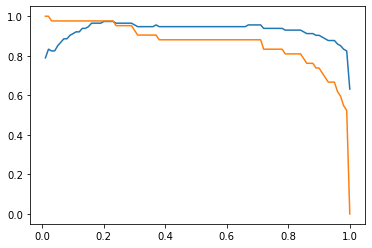

In [22]:
plt.plot(results['Threshold'], results['Accuracy'])
plt.plot(results['Threshold'], results['Recall'])

In [79]:
# ADA BOOST COARSE GRID
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                          DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4)]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True, scoring=['accuracy', 'recall'], refit='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated

params = grid_result.cv_results_['params']


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best: 0.982418 using {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1.0, 'n_estimators': 200}


In [83]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), learning_rate=1, n_estimators=200).fit(X_train, y_train)

prob = model.predict_proba(X_test)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_test, pred)
  recall = recall_score(y_test, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#Threshold 0.45 gives accuracy 96.5% with 100% recall - best 

,Threshold,Accuracy,Recall
44,0.45,0.964912,1.0
43,0.44,0.947368,1.0
42,0.43,0.894737,1.0
41,0.42,0.859649,1.0
40,0.41,0.833333,1.0
...,...,...,...
95,0.96,0.631579,0.0
96,0.97,0.631579,0.0
97,0.98,0.631579,0.0
98,0.99,0.631579,0.0


In [10]:
# ADA BOOST FINE GRID SEARCH
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = np.arange(100, 300, 10)
grid['learning_rate'] = [1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1)]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True, scoring=['accuracy', 'recall'], refit='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated

params = grid_result.cv_results_['params']

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best: 0.982418 using {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1.0, 'n_estimators': 180}


In [24]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate=1, n_estimators=190).fit(X_train, y_train)

prob = model.predict_proba(X_test)[:,1] 
results = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Recall'])

for t in np.arange(0.01, 1.01, 0.01):
  pred = np.where(prob > t, 1, 0)
  accuracy = accuracy_score(y_test, pred)
  recall = recall_score(y_test, pred)
  results = pd.concat([results, pd.DataFrame({'Threshold':t, 'Accuracy':accuracy, 'Recall':recall}, 
                                             index=[0])]).reset_index(drop=True)

results.sort_values(['Recall', 'Accuracy'], ascending=False)

#Threshold 0.45 gives accuracy 97.3% with 100% recall - best 

,Threshold,Accuracy,Recall
44,0.45,0.973684,1.0
43,0.44,0.947368,1.0
42,0.43,0.921053,1.0
41,0.42,0.859649,1.0
40,0.41,0.824561,1.0
...,...,...,...
95,0.96,0.631579,0.0
96,0.97,0.631579,0.0
97,0.98,0.631579,0.0
98,0.99,0.631579,0.0


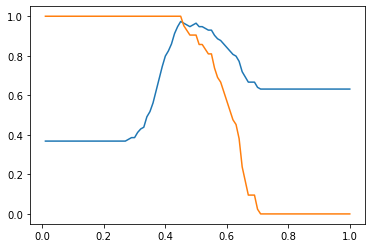

In [20]:
plt.plot(results['Threshold'], results['Accuracy'])
plt.plot(results['Threshold'], results['Recall'])
